In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from io import StringIO

## Part 1. Treasury Yield

### Fetching Data and Global Styling

In [2]:
# Treasury yield curve data URL
URL = "https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025"

# Function to fetch yield data
def fetch_yield_data():
    response = requests.get(URL)
    if response.status_code != 200:
        print("Failed to retrieve data")
        return None

    soup = BeautifulSoup(response.text, "html.parser")

    # Extract table data
    table = soup.find("table")
    if not table:
        print("No table found on the page")
        return None

    # Convert table HTML to DataFrame (Fixing FutureWarning)
    table_html = str(table)
    df = pd.read_html(StringIO(table_html))[0]  # Using StringIO to avoid FutureWarning
    return df

def preprocess_yield_data(df, start_date=None):
    if df is None or df.empty:
        print("No data available.")
        return None

    df['Date'] = pd.to_datetime(df['Date'])
    if start_date is None:
        start_date = datetime.today() - pd.Timedelta(days=7)  # Default to last 7 days
    else:
        start_date = pd.to_datetime(start_date)

    df_recent = df[df['Date'] >= start_date.strftime('%Y-%m-%d')]
    df_recent = df_recent.iloc[[0, -1]]  # Select first and last row within range
    df_recent = df_recent.dropna(axis=1).set_index('Date').T
    return df_recent

def add_texts(ax, fig, title, subtitle, source):
    ax.plot([0.05, .9], [.95, .95], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
    ax.add_patch(plt.Rectangle((0.05, .95), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth=0))
    ax.text(x=0.05, y=.9, s=title, transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=1)
    ax.text(x=0.05, y=.87, s=subtitle, transform=fig.transFigure, ha='left', fontsize=12, alpha=1)
    ax.text(x=0.05, y=0.12, s=source, transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)


def style_yield_curve(ax, fig):
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12)
    ax.yaxis.set_tick_params(pad=2, labelsize=12)
    ax.spines[['top', 'right', 'bottom']].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1.1)
    plt.subplots_adjust(bottom=0.2, top=0.85)
    fig.patch.set_facecolor('white')

df = fetch_yield_data()

### Code: Plotting Yield Curve and Style

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_yield_curve(df, title, subtitle, source, start_date=None):
    df_recent = preprocess_yield_data(df, start_date)
    if df_recent is None:
        return

    fig, ax = plt.subplots(figsize=(12, 7.5), dpi=96)
    colors = ['#808080', '#3EBCD2']
    for i, date in enumerate(df_recent.columns):
        ax.plot(df_recent.index, df_recent[date], linestyle='-', linewidth=1.2, color=colors[i % len(colors)], label=date.strftime('%Y-%m-%d'))

    style_yield_curve(ax, fig)
    add_texts(ax, fig, title, subtitle, source)
    ax.legend(loc="best", fontsize=8)
    plt.show()


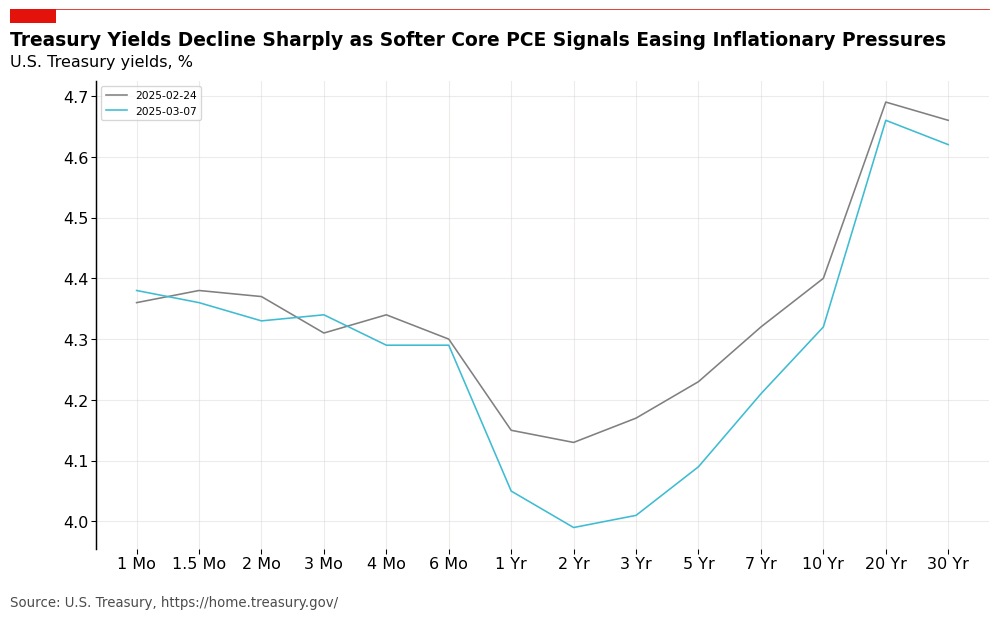

In [4]:
# Example Usage
title = "Treasury Yields Decline Sharply as Softer Core PCE Signals Easing Inflationary Pressures"
subtitle = "U.S. Treasury yields, %"
source = "Source: U.S. Treasury, https://home.treasury.gov/"
start_date = "2025-02-24"  # Example start date
plot_yield_curve(df, title, subtitle, source, start_date)

In [5]:
df_recent = preprocess_yield_data(df, start_date)
df_recent

Date,2025-02-24,2025-03-07
1 Mo,4.36,4.38
1.5 Mo,4.38,4.36
2 Mo,4.37,4.33
3 Mo,4.31,4.34
4 Mo,4.34,4.29
6 Mo,4.30,4.29
1 Yr,4.15,4.05
2 Yr,4.13,3.99
3 Yr,4.17,4.01
5 Yr,4.23,4.09


---
### Column Data: Changes in different Maturity Over a Period

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import datetime, date

def preprocess_column_data(df, start_date, column_name):
    if df is None or df.empty or column_name not in df.columns:
        print("No data available or column not found.")
        return None

    df['Date'] = pd.to_datetime(df['Date']).dt.date
    start_date = pd.to_datetime(start_date).date()
    df_filtered = df[df['Date'] >= start_date]
    return df_filtered[['Date', column_name]]

def plot_column_trend(df, start_date, column_name, title, subtitle, source):
    df_column = preprocess_column_data(df, start_date, column_name)
    if df_column is None:
        return

    fig, ax = plt.subplots(figsize=(12, 7.5), dpi=96)
    ax.plot(df_column['Date'], df_column[column_name], linestyle='-', color='#006BA2', linewidth=1.2)



    # Get min and max values
    min_val = df_column[column_name].min()
    max_val = df_column[column_name].max()
    min_date = df_column[df_column[column_name] == min_val]['Date'].values[0]
    max_date = df_column[df_column[column_name] == max_val]['Date'].values[0]

    # Annotate min and max values
    ax.annotate(f'Min: {min_val:.2f}', xy=(min_date, min_val), xytext=(-30, -20),
                textcoords='offset points', fontsize=10, color='red',
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    ax.annotate(f'Max: {max_val:.2f}', xy=(max_date, max_val), xytext=(-30, 15),
                textcoords='offset points', fontsize=10, color='green',
                arrowprops=dict(facecolor='green', arrowstyle='->'))

    # Ensure min/max values are within y-axis limits
    ax.set_ylim(min_val * 0.98, max_val * 1.02)

    # Increase the number of y-axis ticks
    ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    style_yield_curve(ax, fig)
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))  # Show only date
    add_texts(ax, fig, title, subtitle, source)
    plt.show()


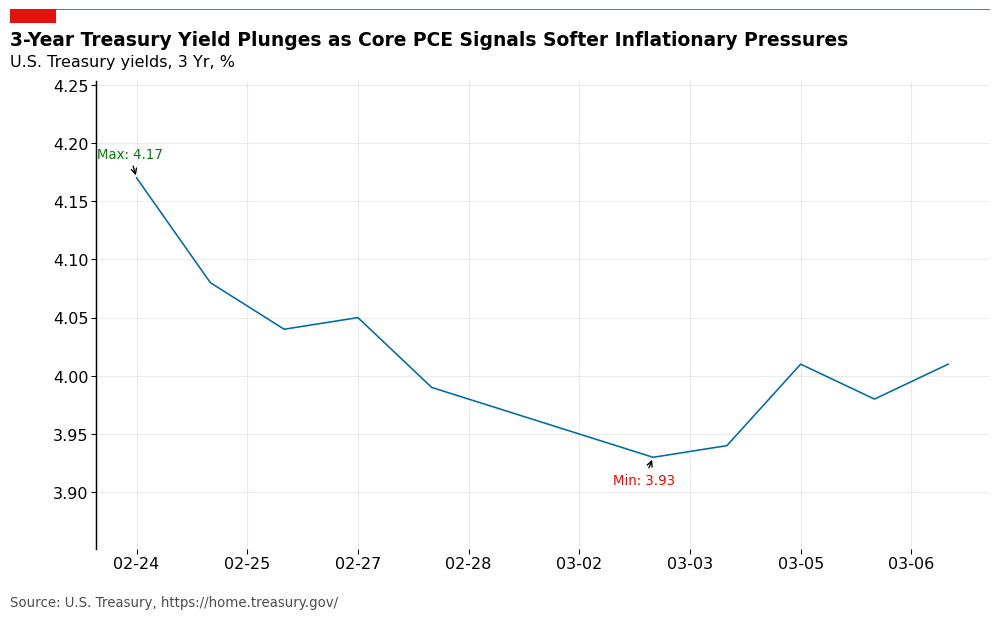

In [7]:
# Example Usage
start_date = "2025-02-24"  # Example start date
target_column = "3 Yr"
title = "3-Year Treasury Yield Plunges as Core PCE Signals Softer Inflationary Pressures"
subtitle = f"U.S. Treasury yields, {target_column}, %"
source = "Source: U.S. Treasury, https://home.treasury.gov/"

plot_column_trend(df, start_date, target_column, title, subtitle, source)

---
## Part 2. Stock Market
### Presets

In [16]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the date range
today = datetime.now().date()
start_date = today - timedelta(days=7)

# Fetch TSLA data
ticker = '3033.HK'
data = yf.download(ticker, start=start_date, end=today, progress=False)

# Ensure data is not empty
if not data.empty:
    # Find the first and last available trading day
    start_price = data['Close'].dropna().iloc[0].item()  # First valid price
    end_price = data['Close'].dropna().iloc[-1].item()  # Last valid price
    first_trading_day = data.index[0].date()
    last_trading_day = data.index[-1].date()  # Last available trading day

    # Calculate return
    weekly_return = (end_price - start_price) / start_price * 100
    print(f"The return for {ticker} from {first_trading_day} to {last_trading_day} is {weekly_return:.2f}%")
else:
    print("No data available for the specified date range.")


The return for 3033.HK from 2025-03-03 to 2025-03-07 is 9.16%


In [17]:
data

Price,Close,High,Low,Open,Volume
Ticker,3033.HK,3033.HK,3033.HK,3033.HK,3033.HK
Date,,,,,
2025-03-03,5.405,5.580,5.34,5.510,1646152102
2025-03-04,5.410,5.475,5.24,5.300,1464720807
2025-03-05,5.650,5.655,5.45,5.495,1153596360
2025-03-06,5.930,5.965,5.78,5.780,1137166516
2025-03-07,5.900,6.070,5.83,5.875,2365619908


In [14]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the date range
today = datetime.now().date()
start_date = today - timedelta(days=7)


ticker = "DX-Y.NYB"

stock = yf.Ticker(ticker)
history = stock.history(period="10d")

history


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-26 00:00:00-05:00,106.169998,106.650002,106.160004,106.419998,0,0.0,0.0
2025-02-27 00:00:00-05:00,106.529999,107.309998,106.519997,107.239998,0,0.0,0.0
2025-02-28 00:00:00-05:00,107.250000,107.660004,107.180000,107.610001,0,0.0,0.0
2025-03-03 00:00:00-05:00,107.559998,107.559998,106.470001,106.750000,0,0.0,0.0
2025-03-04 00:00:00-05:00,106.559998,106.650002,105.529999,105.739998,0,0.0,0.0
2025-03-05 00:00:00-05:00,105.620003,105.769997,104.260002,105.739998,0,0.0,0.0
2025-03-06 00:00:00-05:00,104.320000,104.389999,103.760002,104.059998,0,0.0,0.0
2025-03-07 00:00:00-05:00,104.110001,104.239998,103.459999,103.839996,0,0.0,0.0
2025-03-09 00:00:00-05:00,103.904999,103.855003,103.704002,103.704002,0,0.0,0.0


---
## Appendix
- #### HSI component from Wiki

In [11]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# 维基百科恒生指数页面 URL
url = "https://zh.wikipedia.org/wiki/%E6%81%92%E7%94%9F%E6%8C%87%E6%95%B8"

# 发送请求并获取页面内容
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# 查找所有表格
tables = soup.find_all("table", {"class": "wikitable"})

# 解析目标表格（一般为页面中的第一个或第二个表格）
df_list = pd.read_html(str(tables))

# 选择包含成份股的表格（通常是第一个）
hs_index_df = df_list[8]

# 如果列是 MultiIndex，將其轉換為單層次列
hs_index_df.columns = ['_'.join(col) for col in hs_index_df.columns]

# 保存為 Excel 文件
hs_index_df.to_excel("恒生指数成份股.xlsx", index=False)

print("Excel 文件已保存：恒生指数成份股.xlsx")


C:\Users\ROG\AppData\Local\Temp\ipykernel_10252\3840266527.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_list = pd.read_html(str(tables))


Excel 文件已保存：恒生指数成份股.xlsx


---
## Using Alpha Vantage
- weekly changes

In [12]:
import pandas as pd
import requests
from datetime import datetime, timedelta

# Alpha Vantage API setup
API_KEY = "J2PR8IF137G7JKYA"  # Replace with your actual API key
ticker = "DX-Y.NYB"
BASE_URL = "https://www.alphavantage.co/query"

# Define the date range
today = datetime.now().date()
start_date = today - timedelta(days=10)

# Fetch TSLA data from Alpha Vantage
params = {
    "function": "TIME_SERIES_DAILY",
    "symbol": ticker,
    "outputsize": "compact",
    "apikey": API_KEY,
}

response = requests.get(BASE_URL, params=params)
data = response.json()

if "Time Series (Daily)" in data:
    time_series = data["Time Series (Daily)"]
    df = pd.DataFrame.from_dict(time_series, orient="index")
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()  # Ensure chronological order
    df = df.loc[start_date:today]  # Filter for the last 7 days

    if not df.empty:
        # Extract first and last available closing prices
        start_price = float(df.iloc[0]["4. close"])
        end_price = float(df.iloc[-1]["4. close"])
        first_trading_day = df.index[0].date()
        last_trading_day = df.index[-1].date()

        # Calculate return
        weekly_return = (end_price - start_price) / start_price * 100
        print(f"The return for {ticker} from {first_trading_day} to {last_trading_day} is {weekly_return:.2f}%")
    else:
        print("No data available for the specified date range.")
else:
    print("Error fetching data. Please check your API key and try again.")


Error fetching data. Please check your API key and try again.
